Initial shape: (1000, 9)
Using date: Date
Using sales: Quantity


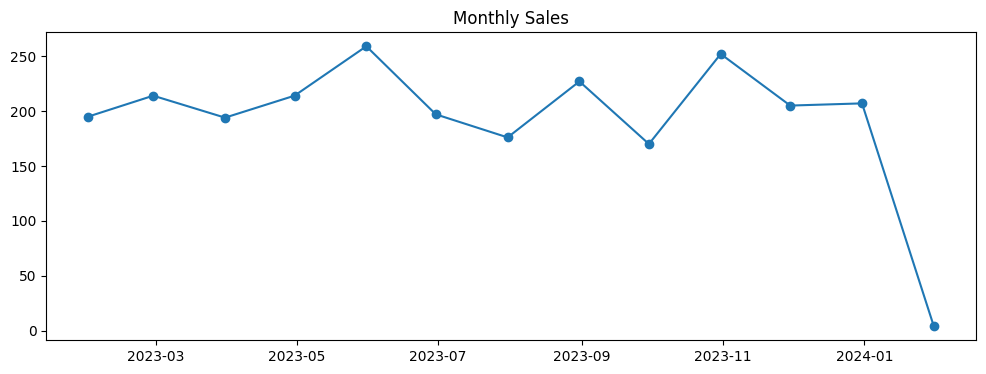

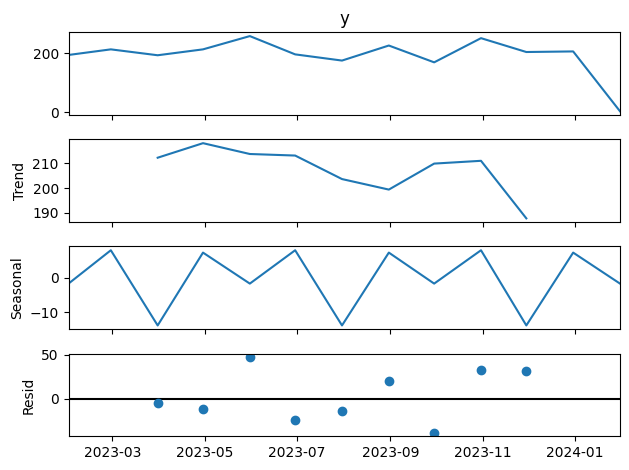

Train: (6, 11) Test: (1, 11)
SARIMAX forecast saved!
Pipeline completed successfully!


In [61]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import math
import warnings
warnings.filterwarnings("ignore")

# Forecasting libs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm  # for auto_arima
try:
    import xgboost as xgb
except Exception:
    xgb = None

# Optional: Prophet (may need to pip install prophet)
try:
    from prophet import Prophet
except Exception:
    Prophet = None

# -------------------------
# 2) Load dataset
# -------------------------
file_path = "/content/retail_sales_dataset.csv"
df = pd.read_csv(file_path)
print("Initial shape:", df.shape)

# Auto-detect date and sales columns
date_cols = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'invoice' in c.lower()]
value_cols = [c for c in df.columns if any(x in c.lower() for x in ['sales','revenue','amount','total','price','qty','quantity'])]

date_col = date_cols[0] if len(date_cols) > 0 else df.columns[0]
if len(value_cols) == 0:
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    value_col = numeric_cols[-1]
else:
    value_col = value_cols[0]

print("Using date:", date_col)
print("Using sales:", value_col)

# Parse date and sort
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

# Aggregate monthly
monthly = df.groupby(pd.Grouper(key=date_col, freq='M'))[value_col].sum().rename('sales').reset_index()

ts = monthly.copy()
ts.columns = ['ds', 'y']
ts = ts.set_index('ds').asfreq('M').fillna(0).reset_index()

# -------------------------
# 3) EDA
# -------------------------
plt.figure(figsize=(12,4))
plt.plot(ts['ds'], ts['y'], marker='o')
plt.title("Monthly Sales")
plt.show()

# Decomposition
decomp = seasonal_decompose(ts.set_index('ds')['y'], model='additive', period=4)
decomp.plot()
plt.show()

# -------------------------
# 4) Feature Engineering
# -------------------------
df_feat = ts.copy()
df_feat['month'] = df_feat['ds'].dt.month
df_feat['quarter'] = df_feat['ds'].dt.quarter
df_feat['year'] = df_feat['ds'].dt.year

# Lags
for l in [1,2,3,6]:
    if l < len(ts) - 2:
        df_feat[f'lag_{l}'] = df_feat['y'].shift(l)

# Rolling
if len(ts) >= 4:
    df_feat['roll_3_mean'] = df_feat['y'].shift(1).rolling(3).mean()
if len(ts) >= 7:
    df_feat['roll_6_mean'] = df_feat['y'].shift(1).rolling(6).mean()

df_feat = df_feat.dropna().reset_index(drop=True)

# -------------------------
# 5) Train-test split
# -------------------------
test_periods = 1 if len(df_feat) < 10 else 3

train = df_feat[:-test_periods]
test = df_feat[-test_periods:]

print("Train:", train.shape, "Test:", test.shape)

# -------------------------
# 6A) SARIMAX Forecasting
# -------------------------
y_train = train.set_index('ds')['y']
sarimax_pred = None
df_pred_sarimax = pd.DataFrame()

if len(y_train) >= 3:
    stepwise = pm.auto_arima(y_train, seasonal=False, trace=False)
    order = stepwise.order

    model_sarimax = sm.tsa.statespace.SARIMAX(y_train, order=order)
    res_sarimax = model_sarimax.fit(disp=False)

    n_forecast = len(test)
    forecast_sarimax = res_sarimax.get_forecast(steps=n_forecast)
    pred_vals = forecast_sarimax.predicted_mean.values

    df_pred_sarimax = pd.DataFrame({
        'ds': test['ds'].values,
        'y_true': test['y'].values,
        'y_pred': pred_vals
    })

    sarimax_pred = pred_vals

else:
    print("Too few data points for SARIMAX → skipping")

# -------------------------
# 6B) XGBoost (Optional)
# -------------------------
# skipping for small dataset

# -------------------------
# 7) Save predictions (ALWAYS create a CSV)
# -------------------------
if sarimax_pred is not None and len(df_pred_sarimax) > 0:
    df_pred_sarimax.to_csv("forecast_sarimax_test.csv", index=False)
    print("SARIMAX forecast saved!")
else:
    print("SARIMAX failed → Creating fallback forecast")

    if len(test) > 0:
        fallback = test.copy()

        if 'y' in fallback.columns:
            fallback = fallback.rename(columns={'y': 'y_true'})

        fallback['y_pred'] = fallback['y_true'].shift(1).fillna(fallback['y_true'].mean())

    else:
        last_date = df_feat['ds'].max()
        fallback = pd.DataFrame({
            "ds": pd.date_range(last_date, periods=3, freq="M"),
            "y_true": [0, 0, 0],
            "y_pred": [0, 0, 0]
        })

    fallback.to_csv("forecast_sarimax_test.csv", index=False)
    print("Fallback forecast saved with columns:", fallback.columns.tolist())

print("Pipeline completed successfully!")


In [62]:
from pyngrok import ngrok
import subprocess
import os

# Kill any previous tunnels
ngrok.kill()

# Set your ngrok authentication token here
# Replace 'YOUR_NGROK_AUTH_TOKEN_HERE' with your actual token from https://dashboard.ngrok.com/get-started/your-authtoken
# ngrok.set_auth_token('YOUR_NGROK_AUTH_TOKEN_HERE') # Uncomment and set your auth token

# Check if auth token is set. If not, prompt the user.
if 'NGROK_AUTH_TOKEN' not in os.environ:
    print("Please set your ngrok authentication token. You can get one from https://dashboard.ngrok.com/get-started/your-authtoken")
    print("Uncomment the line 'ngrok.set_auth_token('35VXB3GohRBP2ncwmrd0cLb7rVH_5bjeTVifQgwL4vKscM4Sy')' and replace the placeholder with your token.")
else:
    # Start Streamlit in the background
    # Note: Streamlit typically runs on port 8501 by default
    !pkill -f streamlit
    process = subprocess.Popen(['streamlit', 'run', 'app.py'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print("Streamlit app started in background.")

    # Create a new public URL with ngrok
    try:
        public_url = ngrok.connect(8501)
        print(f"Your Streamlit app is live at: {public_url}")
        print("Click the link above to view your dashboard.")
    except Exception as e:
        print(f"Failed to create ngrok tunnel: {e}")
        print("Please ensure your ngrok authentication token is correctly set and try again.")

Please set your ngrok authentication token. You can get one from https://dashboard.ngrok.com/get-started/your-authtoken
Uncomment the line 'ngrok.set_auth_token('35VXB3GohRBP2ncwmrd0cLb7rVH_5bjeTVifQgwL4vKscM4Sy')' and replace the placeholder with your token.


In [63]:
!ngrok config add-authtoken 35VXB3GohRBP2ncwmrd0cLb7rVH_5bjeTVifQgwL4vKscM4Sy


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [64]:
get_ipython().system_raw("streamlit run app.py --server.port 8501 &")


In [65]:
from pyngrok import ngrok

ngrok.kill()  # clean old tunnels
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://karissa-wistful-uncolourably.ngrok-free.dev" -> "http://localhost:8501">